In [1]:
import pyd4 
import fibertools as ft
import polars as pl
import pandas as pd
import io
import tempfile
import numpy as np
import subprocess
from numba import njit
import logging
log_format = "[%(levelname)s][Time elapsed (ms) %(relativeCreated)d]: %(message)s"
#log_level = logging.DEBUG if args.verbose else logging.WARNING
log_level = logging.DEBUG
logging.basicConfig(format=log_format, level=log_level)

@njit
def chrom_bg(sts, ens, chrom_len):
    chrom = np.zeros(chrom_len, dtype=np.uint16)
    to_add = np.uint64(1)
    for st, en in zip(sts, ens):
        chrom[st:en] += to_add
    return chrom

def df_to_bg(df, genome):
    bg_data = {}
    for g in df.groupby("ct"):
        chrom = g.ct[0]
        bg_data[chrom] = chrom_bg(g.st.to_numpy(), g.en.to_numpy(), genome[chrom])
    return bg_data

def make_d4_from_df(df, genome, d4_f):
    chroms = list(zip(genome.keys(), genome.values()))
    writer = pyd4.D4Builder(d4_f) \
        .add_chroms(chroms) \
        .for_sparse_data() \
        .get_writer()
    
    for chrom, data in df_to_bg(df, genome).items():
        writer.write_np_array(chrom, 0, data)
    writer.close()

    
def make_temp_d4_from_df(df, genome):
    temp = tempfile.NamedTemporaryFile(suffix='.d4')
    make_d4_from_df(df, genome, temp.name)
    return temp 

def make_union_d4_from_df(df, genome, group_col, d4_f):
    out_files = []
    for idx, g in enumerate(df.groupby([group_col])):
        g_n = g[group_col][0]
        out_files.append((g_n, make_temp_d4_from_df(g, genome)))
        logging.debug(f"Made d4 for group: {g_n}")
            
    merged = pyd4.D4Merger(d4_f)
    for tag, d4 in sorted(out_files):
        merged.add_tagged_track(str(tag), d4.name)
    merged.merge()
    # close files
    [d4.close() for _tag, d4 in out_files]


/Users/mrvollger/miniconda3/envs/fibertools/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [403]:
%%time
all_df = ft.read_in_bed_file("../data/acc.model.results.bed.gz", n_rows=200_000_000)

CPU times: user 2min 50s, sys: 1min 44s, total: 4min 34s
Wall time: 2min 53s


In [408]:
all_df = all_df.with_column(
    pl.when(pl.col("column_9") == "230,230,230").then(101).otherwise(pl.col("column_5")).alias("score")
)
df = all_df.head(100).clone()
all_df.shape, df.shape, all_df.ct.value_counts()

((186972218, 11),
 (100, 11),
 shape: (6, 2)
 ┌───────┬──────────┐
 │ ct    ┆ counts   │
 │ ---   ┆ ---      │
 │ str   ┆ u32      │
 ╞═══════╪══════════╡
 │ chr1  ┆ 55902581 │
 ├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
 │ chr10 ┆ 31733134 │
 ├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
 │ chr11 ┆ 31537782 │
 ├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
 │ chr12 ┆ 31251670 │
 ├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
 │ chr13 ┆ 23188892 │
 ├╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┤
 │ chr14 ┆ 13358159 │
 └───────┴──────────┘)

In [409]:
genome_file = "../data/hg38.chrom.sizes"
genome = { line.split()[0]:int(line.split()[1])  for line in open(genome_file) }

In [410]:
%%time
make_d4_from_df(df, genome, "tmp.d4")
#make_temp_d4_from_df(df, genome)

CPU times: user 5.3 s, sys: 868 ms, total: 6.16 s
Wall time: 2.08 s


In [411]:
%%time 
make_union_d4_from_df(all_df, "score", "m.d4")    

[DEBUG][Time elapsed (ms) 17124614]: Made d4 for group: 16
[DEBUG][Time elapsed (ms) 17127271]: Made d4 for group: 0
[DEBUG][Time elapsed (ms) 17130347]: Made d4 for group: 15
[DEBUG][Time elapsed (ms) 17136021]: Made d4 for group: 14
[DEBUG][Time elapsed (ms) 17140163]: Made d4 for group: 13
[DEBUG][Time elapsed (ms) 17143751]: Made d4 for group: 12
[DEBUG][Time elapsed (ms) 17147763]: Made d4 for group: 11
[DEBUG][Time elapsed (ms) 17151244]: Made d4 for group: 10
[DEBUG][Time elapsed (ms) 17155961]: Made d4 for group: 9
[DEBUG][Time elapsed (ms) 17160991]: Made d4 for group: 25
[DEBUG][Time elapsed (ms) 17168124]: Made d4 for group: 24
[DEBUG][Time elapsed (ms) 17173609]: Made d4 for group: 8
[DEBUG][Time elapsed (ms) 17179656]: Made d4 for group: 23
[DEBUG][Time elapsed (ms) 17183682]: Made d4 for group: 7
[DEBUG][Time elapsed (ms) 17187716]: Made d4 for group: 6
[DEBUG][Time elapsed (ms) 17192418]: Made d4 for group: 22
[DEBUG][Time elapsed (ms) 17264207]: Made d4 for group: 101
[

CPU times: user 6min 49s, sys: 3min 23s, total: 10min 13s
Wall time: 3min 52s


In [7]:
file = pyd4.D4File("../tmp.d4")
print("Tracks living in tihs file", file.list_tracks())
matrix = file.open_all_tracks()


Tracks living in tihs file ['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18', 'q_19', 'q_20', 'q_21', 'q_22', 'q_23', 'q_24', 'q_25', 'q_26', 'q_27', 'q_28', 'q_29', 'q_100', 'q_101']


['q_0',
 'q_1',
 'q_2',
 'q_3',
 'q_4',
 'q_5',
 'q_6',
 'q_7',
 'q_8',
 'q_9',
 'q_10',
 'q_11',
 'q_12',
 'q_13',
 'q_14',
 'q_15',
 'q_16',
 'q_17',
 'q_18',
 'q_19',
 'q_20',
 'q_21',
 'q_22',
 'q_23',
 'q_24',
 'q_25',
 'q_26',
 'q_27',
 'q_28',
 'q_29',
 'q_100',
 'q_101']

In [61]:
track_names = matrix.track_names
q_values = np.array([ max(int(x.strip("q_"))/100, 0.001) for x in track_names ])
log_q_values = - 10 * np.log10(q_values[:-2])
# To enumerate the matix 
rtn = []
for values in matrix.enumerate_values("chr11",4604376,4641595):
    vals = np.array(values[2])
    linker_count = values[2][-2]
    nuc_count = values[2][-1]
    acc_count = vals[:-2].sum()
    log_q_value = (log_q_values * vals[:-2]).sum() 
    rtn.append((linker_count,nuc_count, acc_count, log_q_value))
mat = np.array(rtn)

<AxesSubplot:>

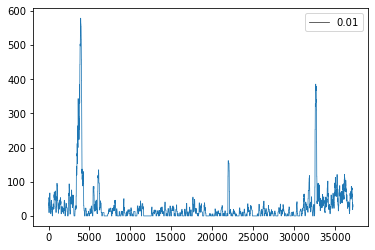

In [62]:
import seaborn as sns
sns.lineplot(x=np.arange(mat.shape[0]), y=mat[:,3], size=0.01)

In [63]:
m = pyd4.D4Merger("../peaks.d4")
for idx in range(4):
    w = (pyd4.D4Builder(f"{idx}.d4")
        .add_chroms([("chr11",5_000_000)])
        # .for_sparse_data()
        .generate_index()
        .get_writer())
    w.write_np_array("chr11", 4604376, mat[:,idx])
    w.close()
    m.add_tagged_track(f"{idx}", f"{idx}.d4")
    
m.merge()



In [108]:
file = pyd4.D4File("../tmp.d4")
#file["chr11"]
z = matrix["chr11"]

In [84]:
y = z[:,:10].T

In [103]:
y.shape
nuc_cov = y[:,-1]
link_cov = y[:,-2]
acc_cov = y[:, :-2].sum(axis=1)
log_q_vals = (y[:,:-2]*log_q_values).sum(axis=1)

nuc_cov, link_cov, acc_cov, log_q_vals

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [107]:
z = matrix["chr11", 0, 1000]
z.shape

(32, 1000)

In [111]:
matrix.

AttributeError: 'D4Matrix' object has no attribute 'mean'